In [2]:
import os
import numpy as np
import pandas as pd
from joblib import dump, load
import sys
import seaborn as sns
import json
sys.path.append(os.path.join(os.path.abspath('../'), 'predictions_collapsed'))
sys.path.append(os.path.join(os.path.abspath('../'), 'src'))
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import glob

from config_loader import (
    D_CONFIG,
    DATASET_SITE_PATH, DATASET_SPLIT_PATH,
    DATASET_FEAT_PER_TSLICE_PATH,
    PROJECT_REPO_DIR, PROJECT_CONDA_ENV_YAML,
    RESULTS_SPLIT_PATH, RESULTS_FEAT_PER_TSTEP_PATH)

sys.path.append(os.path.join(PROJECT_REPO_DIR, 'src'))
sys.path.append(os.path.join(PROJECT_REPO_DIR, 'src', 'rnn'))
from feature_transformation import *
from filter_admissions_by_tslice import get_preprocessed_data
from merge_features_all_tslices import merge_data_dicts, get_all_features_data
import matplotlib.pyplot as plt

In [3]:
labs_df, labs_data_dict, vitals_df, vitals_data_dict, \
    demographics_df, demographics_data_dict, outcomes_df, outcomes_data_dict = get_preprocessed_data(DATASET_SITE_PATH)

df_adt = pd.read_csv(
        os.path.join('/rgi/data/HUF/deidentified_data', 'ADT.txt'),
        delimiter='|')


In [76]:
service_code_dict = {'ANR' : 'Anesthesiology', 'CAR' : 'cardiology', 'CGD' : 'general_surgery_and_digestive',
                     'DER' : 'dermatology', 'DIG' : 'digestive_system', 'END' : 'endocrinology', 'HEM' : 'hematology',
                    'GIN' : 'gynaecology', 'MIR' : 'residents_interns', 'MIV' : 'internal_medicine', 
                    'MNU': 'neuclear_medicine', 'NFR' : 'Nephrology', 'NML' : 'lung', 'NRL' :'neurology',
                    'OBS': 'obstetrics', 'OFT':'opthalmology', 'ONC' : 'oncology', 'ORL' : 'ENT',
                    'REU':'rheumatology', 'URO': 'urology'}

## Plotting stay lengths by service ID

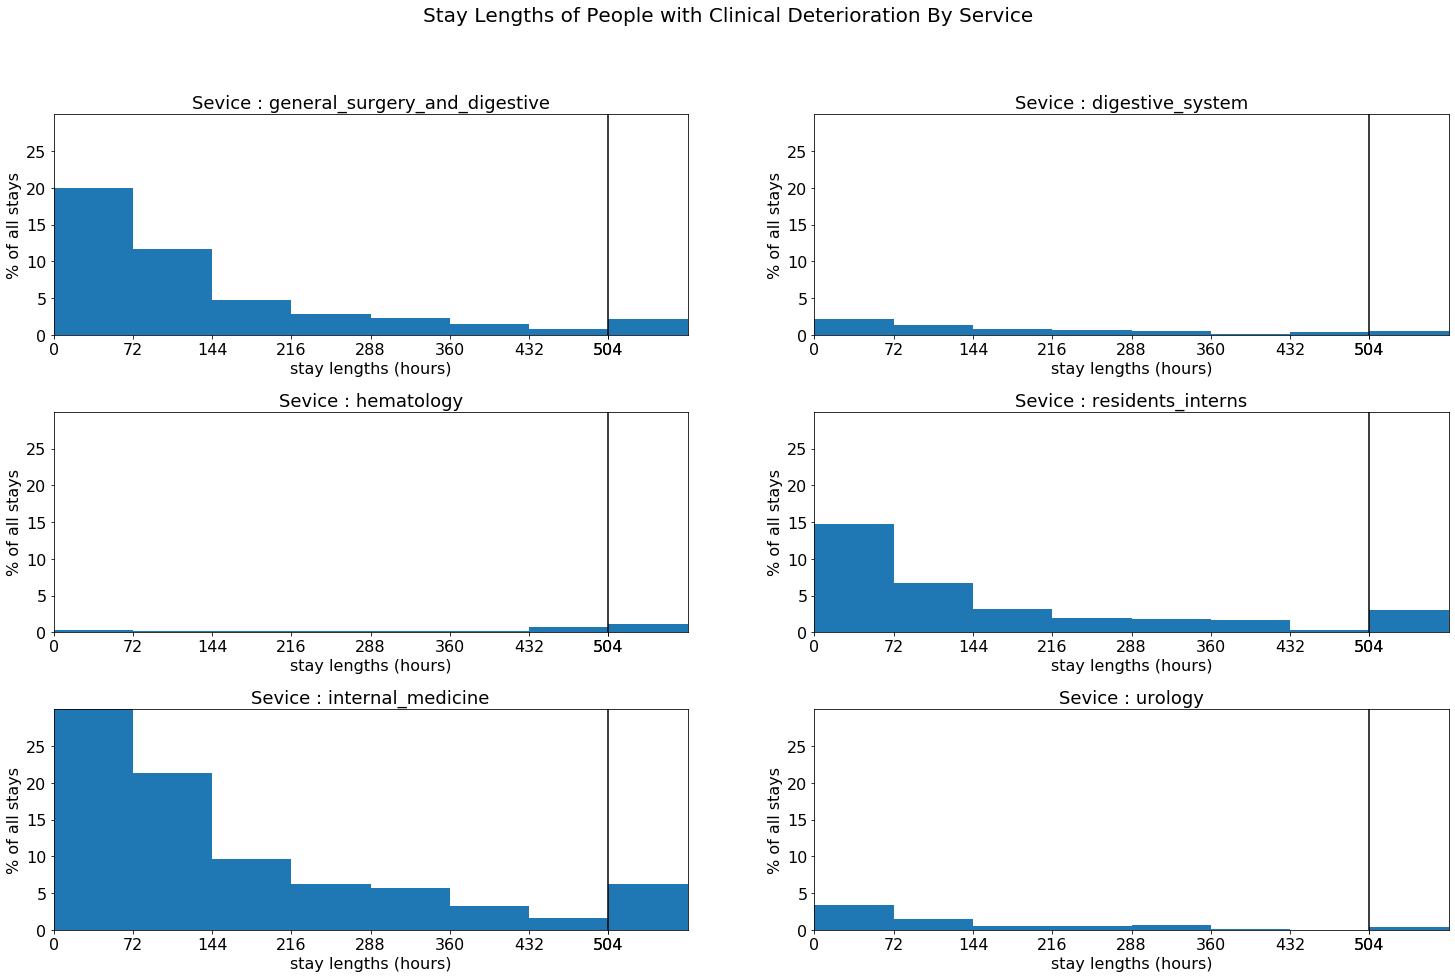

In [89]:
def get_stays_by_service_ids(service_code):
    curr_service_adms_df = df_adt[(df_adt.VALUE_TEXT==service_code) & 
                                  (df_adt.DESCRIPTION == 'service_start_ts')].drop_duplicates(subset='ADMISSION_ID').copy()
    curr_service_adms_df.rename(columns = { 'PATIENT_ID':'patient_id',
                                           'ADMISSION_ID':'hospital_admission_id',
                                           'FACILITY_CD':'facility_code'}, inplace=True)
    return curr_service_adms_df
    


key_cols  = ['patient_id', 'hospital_admission_id', 'facility_code']

# select services to plot
plot_service_list = ['CGD', 'DIG', 'HEM', 'MIR', 'MIV', 'URO']

f,axs =  plt.subplots(3,2, figsize=(25,15))
axs_list = [i for i in axs.reshape(-1,1)]
fontsize=16
for p, service in enumerate(plot_service_list):
    curr_ax = axs_list[p][0]
    df_transfer_to_icu_pos_outcomes = outcomes_df[outcomes_df.clinical_deterioration_outcome==1].copy()
    curr_service_adms_df = get_stays_by_service_ids(service)
    curr_service_stay_lengths = pd.merge(curr_service_adms_df, df_transfer_to_icu_pos_outcomes, 
                                         on=key_cols, how='inner')['stay_length']
    max_los = curr_service_stay_lengths.max()
    max_t = 504
    step=72
    bins = np.arange(0, max_t+1, step)
    if max_los > max_t+1:
        bins=np.insert(bins, len(bins), max_los)
    x = np.asarray(curr_service_stay_lengths)
    curr_ax.hist(x, bins=bins, weights=np.ones(len(x))*100 / len(df_transfer_to_icu_pos_outcomes))
#     curr_ax.hist(x, bins=bins)
    curr_ax.set_xlabel('stay lengths (hours)', fontsize=fontsize)
    curr_ax.set_ylabel('% of all stays', fontsize=fontsize)
    curr_ax.set_xlim([0, max_t+step])
    bins[-1]=max_t
    curr_ax.set_xticks(bins)
    ymin=0
    ymax=30
    curr_ax.vlines(max_t, ymin=ymin, ymax=ymax)
    curr_ax.set_ylim([ymin, ymax])
    curr_ax.set_yticks(np.arange(ymin, ymax, 5))
    curr_ax.set_title('Sevice : %s'%service_code_dict[service], fontsize=fontsize+2)

plt.subplots_adjust(hspace=0.35)
plt.suptitle('Stay Lengths of People with Clinical Deterioration By Service', fontsize=fontsize+4)
plt.show()
f.savefig('stay_lengths_by_service_code.png')

array([  0.,  24.,  48.,  72.,  96., 120., 144., 168., 192., 216., 240.,
       264., 288., 312., 336., 360., 384., 408., 432., 456., 480., 504.,
       528., 552.])

In [71]:
(np.ones(len(x))*100)

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100.])

## Predict Deterioration over time

In [4]:
## Bring 2-3 patient stays from different patients from test set, who clinically deteriorate 

# get the test set's csv and dict
y_test_df = pd.read_csv(os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_test.csv'))
y_test_dict_file = os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_dict.json')

# import the y dict to get the id cols
with open(y_test_dict_file, 'r') as f:
    y_test_dict = json.load(f)
    try:
        y_test_dict['fields'] = y_test_dict['schema']['fields']
    except KeyError:
        pass

id_cols = parse_id_cols(y_test_dict)
# get id's  of 3 patients with clinical deterioration and 3 different stay lengths 
short_stay_ids_df = y_test_df[(y_test_df.clinical_deterioration_outcome==1)&
                           (y_test_df.stay_length<192)][id_cols].copy().reset_index(drop=True)

short_stay_ids_df = short_stay_ids_df.drop_duplicates(subset=id_cols).reset_index(drop=True)

# for each patient get their vitals, labs, demographics
labs_df, labs_data_dict, vitals_df, vitals_data_dict, \
    demographics_df, demographics_data_dict, outcomes_df, outcomes_data_dict = get_preprocessed_data(DATASET_STD_PATH)

vitals = parse_feature_cols(vitals_data_dict)
labs = parse_feature_cols(labs_data_dict)
# collapse features in slices of first 8 hrs, first 16 hrs, ... full stay
short_stay_labs_df = pd.merge(labs_df, short_stay_ids_df, on=id_cols, how='inner')
short_stay_vitals_df = pd.merge(vitals_df, short_stay_ids_df, on=id_cols, how='inner')
short_stay_highfreq_df = pd.merge(short_stay_labs_df, short_stay_vitals_df, on = id_cols + ['hours_since_admission', 
                                                                                            'timestamp'], how='outer')
# short_stay_features_df = pd.merge(short_stay_labs_vitals_df, demographics_df, on=id_cols, how='inner')
highfreq_features_dict = merge_data_dicts([labs_data_dict, vitals_data_dict])
highfreq_features_dict['fields'] = highfreq_features_dict['schema']['fields']

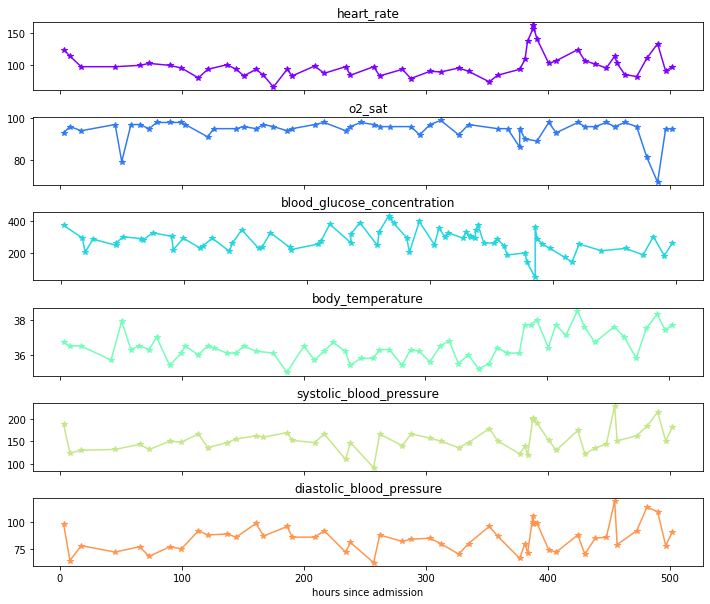

In [48]:
vitals = ['heart_rate','o2_sat',
          'blood_glucose_concentration', 'body_temperature', 
          'systolic_blood_pressure', 'diastolic_blood_pressure'
         ]
f, axs = plt.subplots(len(vitals),1,figsize=(12,10))
plot_subj = vitals_df[vitals_df.hospital_admission_id==13993]



color=cm.rainbow(np.linspace(0,0.8,len(vitals)))
for p,vital in enumerate(vitals):
    
    x = plot_subj.hours_since_admission
    y = plot_subj[vital]
    mask = np.isfinite(y)
    axs[p].plot(x[mask], y[mask], c=color[p,:], marker = '*')
    axs[p].set_title(vital)
    axs[p].set_xlabel('hours since admission')
    if p!=len(vitals)-1:
        axs[p].set_xticklabels([''])
        axs[p].set_xlabel('')
plt.subplots_adjust(hspace=0.4)
plt.show()


# a=vitals_df.groupby(['hospital_admission_id']).count()
# a[a.patient_id>100]


In [ ]:
short_stay_subj = short_stay_ids_df[short_stay_ids_df['hospital_admission_id']==13135366].copy().reset_index(drop=True)
short_stay_subj_highfreq_features_df = pd.merge(short_stay_highfreq_df, short_stay_subj)
time_col = parse_time_col(highfreq_features_dict['schema'])
eval_times = np.arange(24, short_stay_subj_highfreq_features_df[time_col].max(), 8)
collapse_range_features = "std hours_since_measured present slope median min max"
range_pairs = "[('50%','100%'), ('75%','100%'), ('0%','100%'), ('T-6h','T-0h'), ('T-12h','T-0h'), ('T-24h','T-0h')]"
collapsed_features_dict = update_data_dict_collapse(highfreq_features_dict, 
                                                    collapse_range_features, range_pairs)
features_data_dict = merge_data_dicts([collapsed_features_dict, demographics_data_dict]) 

eval_times_collapsed_features_df_list = []
for eval_t in eval_times:
    t_inds = short_stay_subj_highfreq_features_df[time_col]<=eval_t
    curr_highfreq_features_df = short_stay_subj_highfreq_features_df.loc[t_inds, :].copy().reset_index(drop=True)
    tstops_df = short_stay_subj.copy()
    tstops_df.loc[:, 'tstop'] = eval_t
    curr_collapsed_df = collapse_np(curr_highfreq_features_df, highfreq_features_dict, collapse_range_features, range_pairs, tstops_df)
    curr_features_df = pd.merge(curr_collapsed_df, demographics_df, on=id_cols, how='inner')
    eval_times_collapsed_features_df_list.append(curr_features_df)
    

In [ ]:
proba_deterioration_over_time = []
for features_df in eval_times_collapsed_features_df_list:
    feature_cols = parse_feature_cols(features_data_dict['schema'])
    x_test = features_df[feature_cols].values.astype(np.float32)
    proba_deterioration_over_time.append(clf_model.predict_proba(x_test)[0][1])

f, axs = plt.subplots(1,1)
axs.plot(eval_times, proba_deterioration_over_time, '.')
axs.set_xlabel('hours_from_admission')
axs.set_ylabel('probability of deterioration')
axs.set_title('Predcting Deterioration over Time')
plt.show()

## Predicting Performance over time

In [ ]:
def load_data_dict_json(data_dict_file):
    with open(data_dict_file, 'r') as f:
        data_dict = json.load(f)
        try:
            data_dict['fields'] = data_dict['schema']['fields']
        except KeyError:
            pass
    return data_dict


In [ ]:
tslice_folders = os.path.join(DATASET_PERTSTEP_SPLIT_PATH, 'TSTEP=')
outcome_col = 'clinical_deterioration_outcome'
tslices_list = D_CONFIG['EVALUATE_TIMESLICE_LIST']
# tslices_list = D_CONFIG['TRAIN_TIMESLICE_LIST']
roc_dict = dict.fromkeys(tslices_list)
y_test_ids_df = y_test_df[id_cols].drop_duplicates(subset=id_cols).reset_index(drop=True)
scaler=StandardScaler()

for p, tslice in enumerate(tslices_list):
    print('Evaluating on tslice=%s'%tslice)
    tslice_folder = tslice_folders + tslice
    
    # get test set collapsed labs and vitals
    collapsed_vitals_df = pd.read_csv(os.path.join(tslice_folder, 'CollapsedVitalsPerSequence.csv'))
    collapsed_labs_df = pd.read_csv(os.path.join(tslice_folder, 'CollapsedLabsPerSequence.csv'))
    outcomes_df = pd.read_csv(os.path.join(tslice_folder,
                                           'clinical_deterioration_outcomes_filtered_%s_hours.csv'%tslice))
    collapsed_vitals_data_dict = load_data_dict_json(os.path.join(tslice_folder, 'Spec_CollapsedVitalsPerSequence.json'))
    collapsed_labs_data_dict = load_data_dict_json(os.path.join(tslice_folder, 'Spec_CollapsedLabsPerSequence.json'))
    test_vitals_df = pd.merge(collapsed_vitals_df, y_test_ids_df, on=id_cols)
    test_labs_df = pd.merge(collapsed_labs_df, y_test_ids_df, on=id_cols)

    
    # merge them
    test_collapsed_features_df = pd.merge(test_vitals_df, test_labs_df, on=id_cols, how='inner')
    test_features_df = pd.merge(test_collapsed_features_df, demographics_df, on=id_cols)
    if p==0:
        test_features_dict = merge_data_dicts([collapsed_vitals_data_dict, 
                                             collapsed_labs_data_dict, demographics_data_dict])
    
    test_outcomes_df = pd.merge(test_features_df[id_cols], outcomes_df, on=id_cols, how='inner')
    
    
#     # get performance metrics
    feature_cols = parse_feature_cols(test_features_dict['schema'])
    x_test = test_features_df[feature_cols].values
    y_test = test_outcomes_df[outcome_col].values
    
    y_pred = clf_model.predict(x_test)
    y_pred_proba = clf_model.predict_proba(x_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print('ROC for tslice=%s is %.3f'%(tslice, roc_auc))

In [2]:
perf_df = pd.read_csv('/tmp/results/madrid/v20200424/split-by=patient_id/features_per_timestep/perf.csv')

In [3]:
perf_df

,average_precision,balanced_accuracy,log_loss,model,percentile,roc_auc,tslice
0,0.024641,0.521923,1.764843,logistic_regression,5.0,0.581095,8
1,0.025136,0.526268,1.774020,logistic_regression,50.0,0.588905,8
2,0.025895,0.539391,1.778199,logistic_regression,95.0,0.597143,8
3,0.029478,0.555770,1.013362,random_forest,5.0,0.636325,8
4,0.031899,0.575428,1.016404,random_forest,50.0,0.658696,8
...,...,...,...,...,...,...,...
103,0.272138,0.834827,0.420764,logistic_regression,50.0,0.889945,90%
104,0.294870,0.844052,0.423075,logistic_regression,95.0,0.897884,90%
105,0.511413,0.833986,0.163654,random_forest,5.0,0.928155,90%
106,0.528593,0.834967,0.165400,random_forest,50.0,0.931344,90%


In [9]:
tslices_list = list(perf_df['tslice'].unique())
neg_tslices_list = [i for i in tslices_list if '-' in i]
perc_tslices_list = [i for i in tslices_list if '%' in i]

pos_tslices_list = []
for i in tslices_list:
    if (i not in neg_tslices_list) & (i not in perc_tslices_list):
        pos_tslices_list.append(i)
        
    

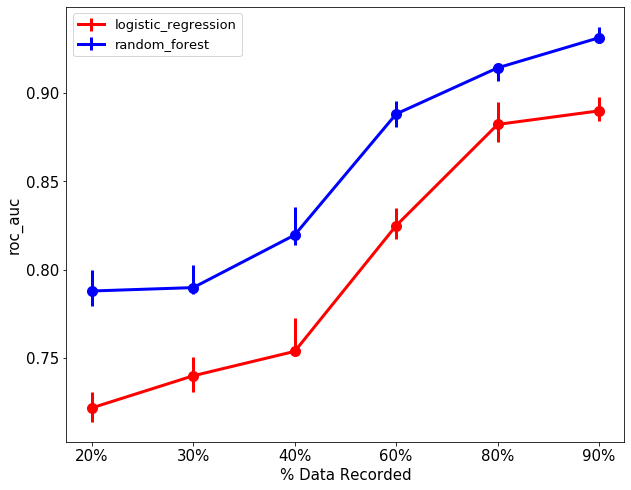

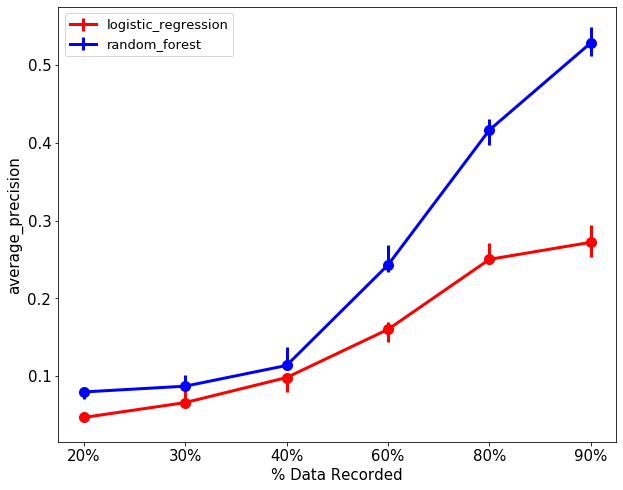

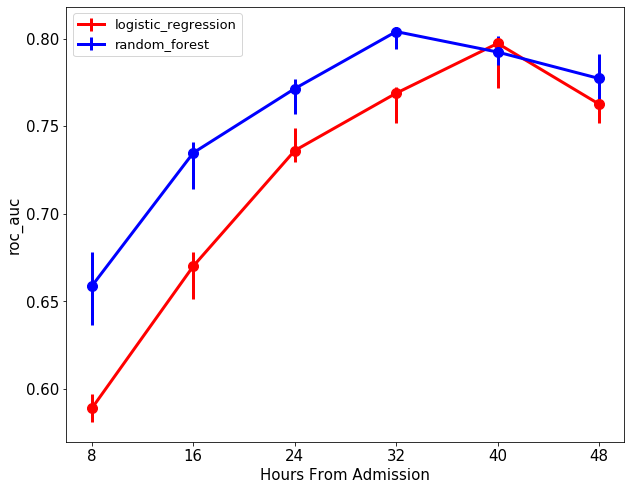

In [ ]:
tslice_grouped_list = [perc_tslices_list, pos_tslices_list, neg_tslices_list]
perf_measures = ['roc_auc', 'average_precision']
fontsize=15
for x in tslice_grouped_list:
    for perf_measure in perf_measures:
        f, axs = plt.subplots(figsize=[10,8])
        model_colors=['r', 'b']
        for p, model in enumerate(perf_df.model.unique()):
            inds = (perf_df.model==model) & (perf_df.tslice.isin(x))
            cur_df = perf_df.loc[inds, :].copy()

            y = cur_df.loc[cur_df.percentile==50, perf_measure].values
            y_err  = np.zeros((2, len(x)))
            y_err[0,:] = y - cur_df.loc[cur_df.percentile==5, perf_measure].values
            y_err[1,:] = cur_df.loc[cur_df.percentile==95, perf_measure].values - y
            
            axs.errorbar(x=x, y=y, yerr=y_err, label=model, fmt='.-', linewidth=3, color=model_colors[p])
            axs.plot(x, y, '.', markersize=20, color=model_colors[p])
            
        if x==neg_tslices_list:
            axs.invert_xaxis()
            axs.set_xlabel('Hours Until Deterioration', fontsize=fontsize)
        elif x==perc_tslices_list:
            axs.set_xlabel('% Data Recorded', fontsize=fontsize)
        elif x==pos_tslices_list:
            axs.set_xlabel('Hours From Admission', fontsize=fontsize)

        axs.set_ylabel(perf_measure, fontsize=fontsize)
        axs.legend(fontsize=fontsize-2, loc='upper left')
        axs.tick_params(labelsize=fontsize)
        plt.show()
            

    

In [100]:
axs.tick_params

<bound method _AxesBase.tick_params of <matplotlib.axes._subplots.AxesSubplot object at 0x7f17faee4d00>>

In [14]:
short_stay_ids = glob.glob('/tmp/results/madrid/v20200424/split-by=patient_id/features_per_timestep/long_stays_predict_proba/*')
short_stay_ids = [i.split('/')[-1].split('_')[0] for i in short_stay_ids]

In [15]:
print(short_stay_ids)

['12702290', '19160387', '19806342', '19222313', '17863017']
